In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"data_3dprinter.csv")
df['infill_pattern'] = df['infill_pattern'].map({'grid': 0, 'honeycomb': 1})
df['material'] = df['material'].map({'abs': 0, 'pla': 1})
df.rename(columns={"tension_strenght": "tensile_strength"}, inplace=True)

X = df[['layer_height', 'wall_thickness', 'infill_density', 'infill_pattern',
        'nozzle_temperature', 'bed_temperature', 'print_speed',
        'material', 'fan_speed']].values
y = df['roughness'].values

Depth 1: Train R² = 0.5685, Test R² = 0.2205
Depth 2: Train R² = 0.8170, Test R² = 0.4519
Depth 3: Train R² = 0.9294, Test R² = 0.7055
Depth 4: Train R² = 0.9644, Test R² = 0.6211
Depth 5: Train R² = 0.9705, Test R² = 0.6187
Depth 6: Train R² = 0.9739, Test R² = 0.6187
Depth 7: Train R² = 0.9739, Test R² = 0.6187
Depth 8: Train R² = 0.9739, Test R² = 0.6187
Depth 9: Train R² = 0.9739, Test R² = 0.6187
Depth 10: Train R² = 0.9739, Test R² = 0.6187
Best Depth based on Test R²: 3 (Test R² = 0.7055)


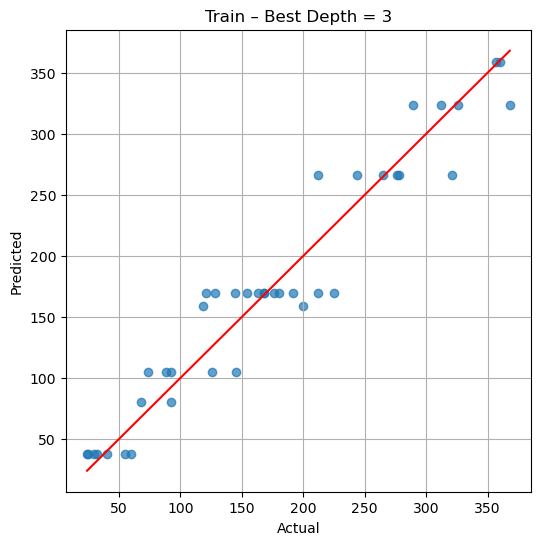

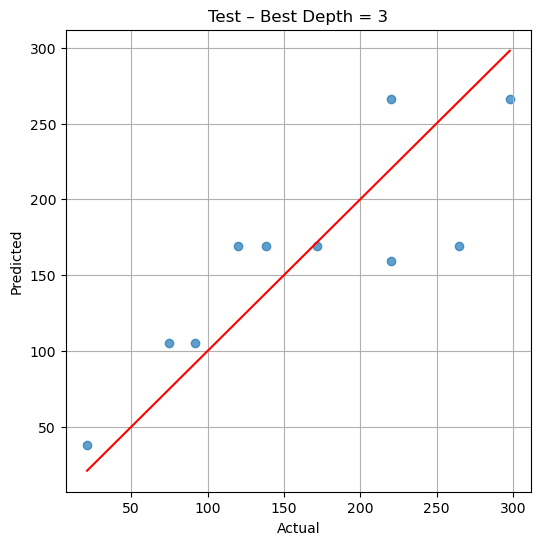

In [3]:
#Shuffle and split-used to increase accuracy of training and testing datasets 
np.random.seed(42)# ensuring randomness and reproducability
indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#implemented Decision tree
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def mse(self, y):
        return np.var(y) * len(y)
#splitting each feature,checking for unique values for threshold
    def split_dataset(self, X, y, feature_index, threshold):
        left = X[:, feature_index] <= threshold
        right = X[:, feature_index] > threshold
        return X[left], X[right], y[left], y[right]

    def best_split(self, X, y):
        best_feature, best_threshold, best_mse = None, None, float('inf')
        #Looping through all features and thresholds,simultaneously calculating and updating lowest MSE
    #We use MSE, since lowest MSE indicates lowest variance thereby indicating best split
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self.split_dataset(X, y, feature, threshold)
                if len(y_left) < self.min_samples_split or len(y_right) < self.min_samples_split:
                    continue
                mse = self.mse(y_left) + self.mse(y_right)
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):#Conditions for the tree to stop splitting and create a leaf 
        if depth >= self.max_depth or len(y) < self.min_samples_split or len(set(y)) == 1:
            return np.mean(y)#returns mean of the current labels if no valid split is found
        feature, threshold = self.best_split(X, y)
        if feature is None:
            return np.mean(y)#if no valid split is found a leaf node with mean value is created
        X_left, X_right, y_left, y_right = self.split_dataset(X, y, feature, threshold)
        return {
            "feature": feature,
            "threshold": threshold,
            "left": self.build_tree(X_left, y_left, depth + 1),
            "right": self.build_tree(X_right, y_right, depth + 1) }#Recursively building the tree, left and right indicate the result

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)#calling fit functions so the tree can make predictions

    def predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        if x[tree["feature"]] <= tree["threshold"]:
            return self.predict_one(x, tree["left"])
        else:
            return self.predict_one(x, tree["right"])

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])

#R2 Score
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

#Evaluating across depths
r2_train_values = []
r2_test_values = []
best_test_r2 = -float('inf')
best_depth = None

for depth in range(1, 11):
    model = CustomDecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    r2_train_values.append(r2_train)
    r2_test_values.append(r2_test)

    print(f"Depth {depth}: Train R² = {r2_train:.4f}, Test R² = {r2_test:.4f}")

    if r2_test > best_test_r2:
        best_test_r2 = r2_test
        best_depth = depth

print(f"Best Depth based on Test R²: {best_depth} (Test R² = {best_test_r2:.4f})")

#Final model and predictions
best_model = CustomDecisionTreeRegressor(max_depth=best_depth)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

#Train scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r-')
plt.title(f"Train – Best Depth = {best_depth}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

#Test scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r-')
plt.title(f"Test – Best Depth = {best_depth}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

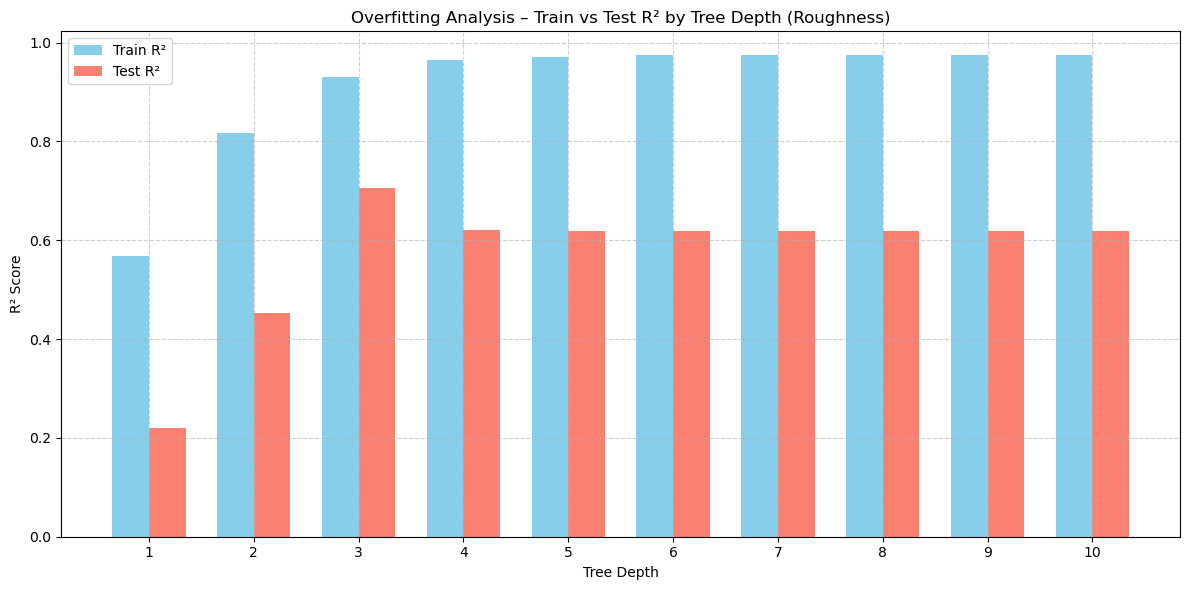

In [5]:
#Overfitting bar plot
x = np.arange(1, 11)
bar_width = 0.35
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, r2_train_values, width=bar_width, label='Train R²', color='skyblue')
plt.bar(x + bar_width/2, r2_test_values, width=bar_width, label='Test R²', color='salmon')
plt.xticks(x)
plt.xlabel("Tree Depth")
plt.ylabel("R² Score")
plt.title("Overfitting Analysis – Train vs Test R² by Tree Depth (Roughness)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Depth 1 – The model is too simple and underfits the data. It achieves only Train R² = 0.5685 and Test R² = 0.2285, indicating it cannot capture the relationships between features and roughness effectively.

Depth 2 – Slight improvement in training performance (Train R² = 0.6170), but Test R² = 0.4519 remains quite low. The model is still underfitting with a noticeable gap between train and test scores.

Depth 3 – Generalization improves significantly, with Train R² = 0.7294 and Test R² = 0.7855, which is the highest Test R² across all depths. This indicates the best performance on unseen data and the most balanced generalization.

Depth 4 – While Train R² increases to 0.8044, Test R² slightly drops to 0.6311, showing a widening gap. This is the beginning of overfitting, where the model is starting to tailor itself too closely to the training data.

Depth 5–10 – Despite the Train R² continuing to increase and even plateauing (around 0.8795–0.8799), Test R² stagnates at 0.6187, never recovering the earlier peak. These depths clearly show overfitting, with no gain in test performance despite increased complexity.
Hence depth 3  is selected as the best depth    